### Вводная

    Вас пригласили поучаствовать в одном из проектов UNICEF — международного подразделения ООН,
чья миссия состоит в повышении уровня благополучия детей по всему миру.

    Cуть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике,
чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

    И сделать это можно с помощью модели, которая предсказывала бы результаты госэкзамена по математике для каждого ученика
школы (вот она, сила ML!). Чтобы определиться с параметрами будущей модели, проведите разведывательный анализ данных
и составьте отчёт по его результатам. 


    Описание датасета
    Посмотрим на переменные, которые содержит датасет:



1 school — аббревиатура школы, в которой учится ученик

2 sex — пол ученика ('F' - женский, 'M' - мужской)

3 age — возраст ученика (от 15 до 22)

4 address — тип адреса ученика ('U' - городской, 'R' - за городом)

5 famsize — размер семьи('LE3' <= 3, 'GT3' >3)

6 Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

7 Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

8 Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

9 Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

10 Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

11 reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

12 guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

13 traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

14 studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

15 failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

16 schoolsup — дополнительная образовательная поддержка (yes или no)

17 famsup — семейная образовательная поддержка (yes или no)

18 paid — дополнительные платные занятия по математике (yes или no)

19 activities — дополнительные внеучебные занятия (yes или no)

20 nursery — посещал детский сад (yes или no)

21 higher — хочет получить высшее образование (yes или no)

22 internet — наличие интернета дома (yes или no)

23 romantic — в романтических отношениях (yes или no)

24 famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

25 freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)

26 goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

27 health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

28 absences — количество пропущенных занятий

29 score — баллы по госэкзамену по математике

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas.api.types import is_numeric_dtype
from itertools import combinations
from scipy.stats import ttest_ind


pd.set_option('display.max_rows', 30)  # показывать больше строк
pd.set_option('display.max_columns', 30)  # показывать больше колонок

df = pd.read_csv('stud_math.csv')

In [123]:
# Предобработка.


# Функция по сбору информации по каждому столбцу

def info_column(column):
    print('Число уникальных значений:', df[column].nunique(), '\n')
    print('Число упоминания каждого значения: \n',
          df[column].value_counts(), '\n')
    print('Число пустых значений в столбце:',
          (df[column].isnull()).sum(), '\n')
    return  # df.loc[:, [column]].info()


# Пропишем функцию расчета IQR и квартилей. И прорисовку  их графика

def IQR_perc(column):
    IQR = df[column].quantile(0.75) - df[column].quantile(0.25)
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)

    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR),
          "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

    df[column].loc[df[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(
        bins=20, range=(start_point, end_point), label='IQR')
    return plt.legend()


# Простановка в столбец вместо пропусков наиболее часто встречаемое значение - mode

def insert_mode(column):
    df[column].fillna(df[column].mode()[0], inplace=True)
    return


# Простановка вместо пропусков округленное среднее значение - mean (!В результате округления оно в принципе == mode!)

def insert_mean(column):
    mean_value = round(df[column].mean())
    df[column].fillna(float(mean_value), inplace=True)
    return


# прорисовка гистограммы исходных данных
def hist_source_data(column):
    df[column].hist(alpha=0.4, bins=20, range=(
        start_point, end_point), label='Исходные данные {}'. format(column))
    plt.legend()
    return

In [124]:
len(df.columns)

30

In [125]:
df.head(20)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


### Первичный отсмотр данных

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [127]:
df.columns = map(str.lower, df.columns)

###  Первичный анализ данных в столбцах.

In [128]:
# В виду того, что значения столбца "studytime,granular" равны значениям столбца "study",
# умноженные на "-3", удаляем его из датафрейма
df = df.drop(['studytime, granular'], axis=1)

In [129]:
# описываем функцию, заменяющую в строковых столбцах  пробел на None

def clear_column(column):
    return df[column].astype(str).apply(lambda x: None if x.strip() == '' else x)


for col in list_obj:
    clear_column(col)

## 1. School

In [130]:
column = 'school'
info_column(column)
# School имеет всего 2 значения: GP и MS. GP в 7.5 раз  больше, чем MS. Пустых значений нет

Число уникальных значений: 2 

Число упоминания каждого значения: 
 GP    349
MS     46
Name: school, dtype: int64 

Число пустых значений в столбце: 0 



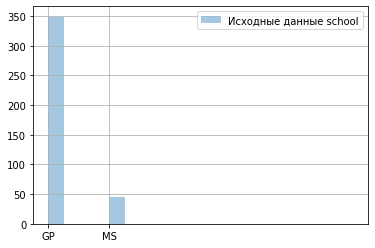

In [131]:
# Задаем границы графика распределения
start_point = 0
end_point = 5
hist_source_data(column)

## 2. Sex

In [132]:
column = 'sex'
info_column(column)
# Пустых значений нет. Девочек чуть больше, чем мальчиков

Число уникальных значений: 2 

Число упоминания каждого значения: 
 F    208
M    187
Name: sex, dtype: int64 

Число пустых значений в столбце: 0 



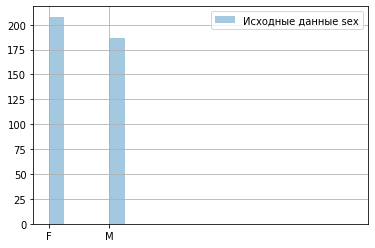

In [133]:
hist_source_data(column)

## 3. Age

In [134]:
column = 'age'
info_column(column)
# Возраст от 16 до 22.Пустых значений нет

Число уникальных значений: 8 

Число упоминания каждого значения: 
 16    104
17     98
18     82
15     82
19     24
20      3
22      1
21      1
Name: age, dtype: int64 

Число пустых значений в столбце: 0 



25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  Границы выбросов: [13.0, 21.0].


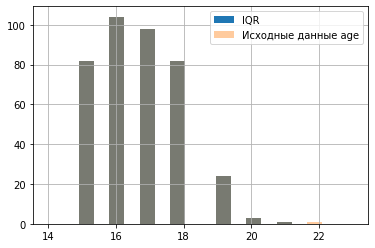

In [135]:
# Задаем границы графика распределения
start_point = 14
end_point = 23

IQR_perc(column)  # вызываем функцию расчета IQR и квартилей

# прорисовывыаем поверх распределение исходных данных
hist_source_data(column)

# Т.к. в описании указано, что возраст учащихся до 22 лет включительно, не будем удалять 22 года как выброс

## 4. Address

In [136]:
column = 'address'
info_column(column)

Число уникальных значений: 2 

Число упоминания каждого значения: 
 U    295
R     83
Name: address, dtype: int64 

Число пустых значений в столбце: 17 



In [137]:
df[df.address.isnull()]

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
52,GP,M,15,NaN,LE3,A,4.0,2.0,health,NaN,other,father,2.0,1.0,1.0,no,NaN,no,no,yes,yes,NaN,no,5.0,5.0,5.0,5.0,6.0,50.0
75,GP,M,15,NaN,GT3,T,4.0,3.0,teacher,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,NaN,NaN,3.0,3.0,5.0,6.0,50.0
92,GP,F,16,NaN,LE3,T,NaN,1.0,other,other,home,father,1.0,2.0,0.0,yes,yes,no,no,yes,yes,no,no,3.0,3.0,NaN,2.0,4.0,30.0
96,GP,M,16,NaN,GT3,NaN,4.0,3.0,services,other,reputation,mother,2.0,1.0,0.0,yes,yes,NaN,yes,no,NaN,yes,no,3.0,3.0,3.0,4.0,2.0,75.0
159,GP,M,16,NaN,GT3,T,3.0,NaN,other,services,course,father,1.0,2.0,1.0,no,yes,yes,no,yes,yes,yes,yes,4.0,5.0,5.0,5.0,4.0,60.0
168,GP,F,16,NaN,GT3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,no,yes,yes,no,5.0,1.0,5.0,4.0,0.0,0.0
241,GP,M,17,NaN,LE3,A,4.0,4.0,teacher,other,course,mother,NaN,2.0,0.0,no,yes,yes,no,yes,yes,yes,no,3.0,3.0,NaN,4.0,2.0,60.0
254,GP,M,17,NaN,NaN,T,2.0,1.0,other,other,course,mother,1.0,1.0,0.0,no,no,no,no,no,yes,yes,no,4.0,4.0,2.0,5.0,NaN,60.0
270,GP,F,19,NaN,GT3,T,3.0,3.0,other,services,home,other,1.0,2.0,2.0,no,yes,yes,yes,yes,yes,yes,no,4.0,3.0,5.0,5.0,NaN,NaN


In [138]:
# Находим среднее  timetravel для каждого типа адреса
mean_time_r = df.groupby('address')['traveltime'].mean().loc['R']
mean_time_u = df.groupby('address')['traveltime'].mean().loc['U']

In [139]:
# Заполняем address следующим образом: сравниваем абсолютные значения разностей timetravel
# и его средних для разных типов address
for i in df[df.address.isnull()].index:
    if not np.isnan(df.traveltime.loc[i]):
        if abs(df.traveltime.loc[i]-mean_time_r) < abs(df.traveltime.loc[i]-mean_time_u):
            df.address.loc[i] = 'R'
        else:
            df.address.loc[i] = 'U'

C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [140]:
# Удаляем оставшиеся 3 строки с пустым address и traveltime - данные столбцы напрямую взаимосвязаны, и мы не сможем определить какие значения присвоить пропущенным значениям
df.dropna(subset=['address'], inplace=True)

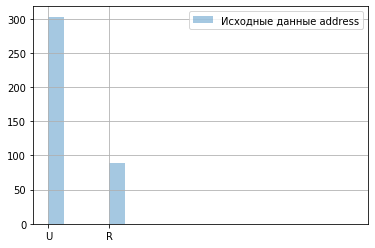

In [141]:
# Задаем границы графика распределения
start_point = 0
end_point = 5
hist_source_data(column)

## 5. Famsize

In [142]:
column = 'famsize'
info_column(column)

Число уникальных значений: 2 

Число упоминания каждого значения: 
 GT3    259
LE3    106
Name: famsize, dtype: int64 

Число пустых значений в столбце: 27 



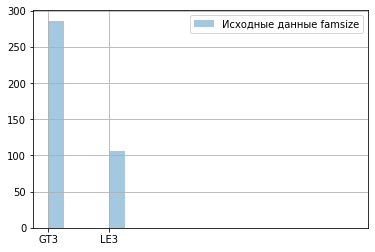

In [143]:
# присвоим пропущеным значениям наиболее часто встречающееся значение
insert_mode(column)
hist_source_data(column)

## 6.  Pstatus

In [144]:
column = 'pstatus'
info_column(column)

Число уникальных значений: 2 

Число упоминания каждого значения: 
 T    312
A     35
Name: pstatus, dtype: int64 

Число пустых значений в столбце: 45 



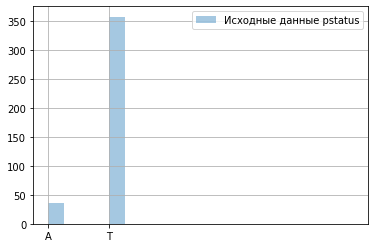

In [145]:
# присвоим пропущеным значениям наиболее часто встречающееся значение
insert_mode(column)
hist_source_data(column)

## 7. Medu

In [146]:
column = 'medu'
info_column(column)

Число уникальных значений: 5 

Число упоминания каждого значения: 
 4.0    129
2.0    101
3.0     97
1.0     59
0.0      3
Name: medu, dtype: int64 

Число пустых значений в столбце: 3 



25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].


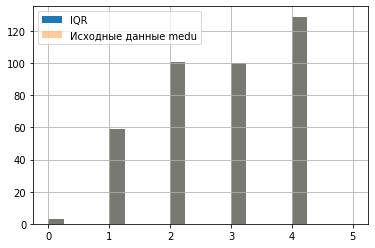

In [147]:
# присвоим пропускам округленное среднее значение (зачастую оно же mode) medu
insert_mean(column)

start_point = 0
end_point = 5

IQR_perc(column)
hist_source_data(column)

# Выбросов нет

## 8. Fedu

In [148]:
column = 'fedu'
info_column(column)

Число уникальных значений: 6 

Число упоминания каждого значения: 
 2.0     105
3.0      95
4.0      87
1.0      78
0.0       2
40.0      1
Name: fedu, dtype: int64 

Число пустых значений в столбце: 24 



In [149]:
# Удалим строку с явно неправильным значением
df = df.drop(np.where(df.fedu == 40.0)[0])

25-й перцентиль: 2.0, 75-й перцентиль: 3.0, IQR: 1.0,  Границы выбросов: [0.5, 4.5].


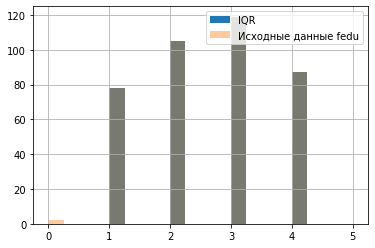

In [150]:
insert_mean(column)

start_point = 0
end_point = 5

IQR_perc(column)
hist_source_data(column)

# 0  - в пределах нормы: не удаляем

## 9. Mjob

In [151]:
column = 'mjob'
info_column(column)

Число уникальных значений: 5 

Число упоминания каждого значения: 
 other       132
services     97
at_home      58
teacher      54
health       31
Name: mjob, dtype: int64 

Число пустых значений в столбце: 19 



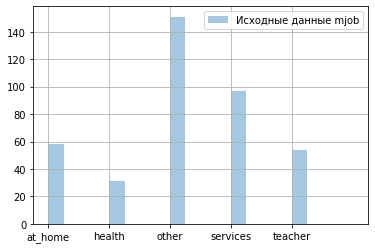

In [152]:
# присвоим пропущеным значениям работы отцов наиболее часто встречающееся значение - other
insert_mode(column)
hist_source_data(column)

## 10. Fjob

In [153]:
column = 'fjob'
info_column(column)

Число уникальных значений: 5 

Число упоминания каждого значения: 
 other       194
services    102
teacher      29
at_home      15
health       15
Name: fjob, dtype: int64 

Число пустых значений в столбце: 36 



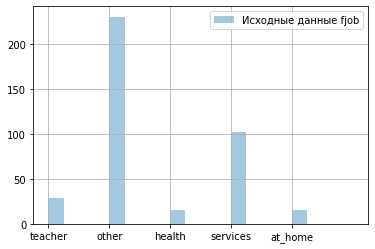

In [154]:
# присвоим пропущеным значениям работы матерей наиболее часто встречающееся значение - other
insert_mode(column)
hist_source_data(column)

## 11. Reason

In [155]:
column = 'reason'
info_column(column)

Число уникальных значений: 4 

Число упоминания каждого значения: 
 course        136
home          103
reputation    101
other          34
Name: reason, dtype: int64 

Число пустых значений в столбце: 17 



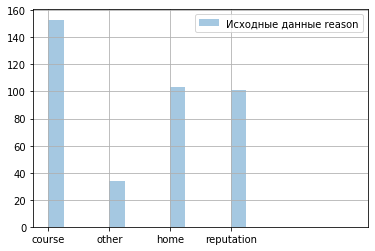

In [156]:
# присвоим пропущенным значениям причины выбора школы наиболее часто встречающееся значение - course
insert_mode(column)
hist_source_data(column)

## 12. Guardian

In [157]:
column = 'guardian'
info_column(column)

Число уникальных значений: 3 

Число упоминания каждого значения: 
 mother    247
father     85
other      28
Name: guardian, dtype: int64 

Число пустых значений в столбце: 31 



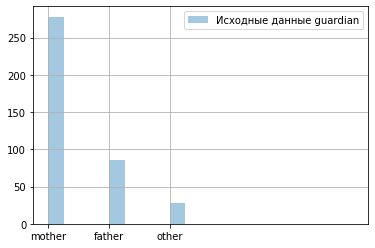

In [158]:
# присвоим пропущенным значениям наиболее часто встречающееся значение - mother
insert_mode(column)
hist_source_data(column)

## 13. traveltime

In [159]:
column = 'traveltime'
info_column(column)

Число уникальных значений: 4 

Число упоминания каждого значения: 
 1.0    242
2.0     96
3.0     21
4.0      7
Name: traveltime, dtype: int64 

Число пустых значений в столбце: 25 



25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].


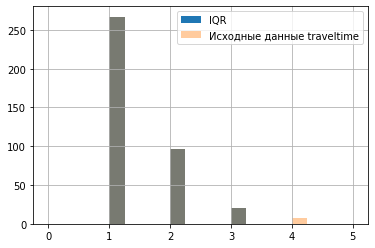

In [160]:
# присвоим пропущенным значениям округленное среднее значение
insert_mean(column)

IQR_perc(column)
hist_source_data(column)
# 4 - в пределах нормы. Не удаляем

## 14. Studytime

In [161]:
column = 'studytime'
info_column(column)

Число уникальных значений: 4 

Число упоминания каждого значения: 
 2.0    193
1.0    103
3.0     61
4.0     27
Name: studytime, dtype: int64 

Число пустых значений в столбце: 7 



25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].


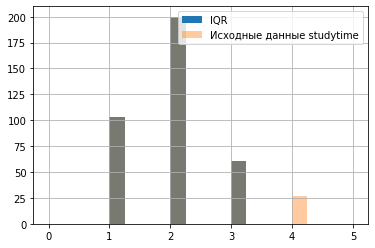

In [162]:
# присвоим пропущенным значениям округленное среднее значение
insert_mean(column)

IQR_perc(column)
hist_source_data(column)
# 4 - в пределах нормы. Не удаляем

## 15. Failures

In [163]:
column = 'failures'
info_column(column)

Число уникальных значений: 4 

Число упоминания каждого значения: 
 0.0    289
1.0     49
2.0     16
3.0     15
Name: failures, dtype: int64 

Число пустых значений в столбце: 22 



25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].


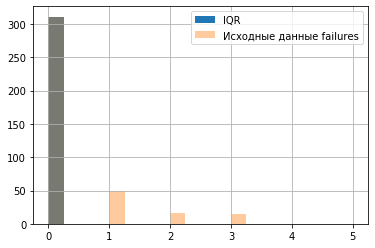

In [164]:
# присвоим пропущенным значениям округленное среднее значение
insert_mean(column)

IQR_perc(column)
hist_source_data(column)
# 1-3  в пределах нормы. Не удаляем

## 16. schoolsup

In [165]:
column = 'schoolsup'
info_column(column)

Число уникальных значений: 2 

Число упоминания каждого значения: 
 no     331
yes     51
Name: schoolsup, dtype: int64 

Число пустых значений в столбце: 9 



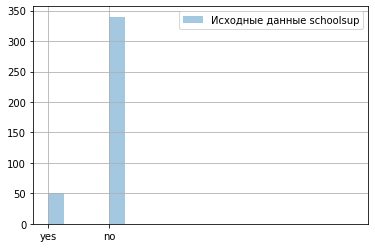

In [166]:
insert_mode(column)
hist_source_data(column)

## 17. Famsup

In [167]:
column = 'famsup'
info_column(column)

Число уникальных значений: 2 

Число упоминания каждого значения: 
 yes    216
no     136
Name: famsup, dtype: int64 

Число пустых значений в столбце: 39 



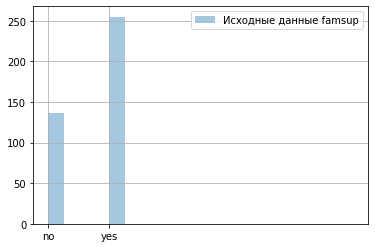

In [168]:
insert_mode(column)
hist_source_data(column)

## 18. Paid

In [169]:
column = 'paid'
info_column(column)

Число уникальных значений: 2 

Число упоминания каждого значения: 
 no     198
yes    153
Name: paid, dtype: int64 

Число пустых значений в столбце: 40 



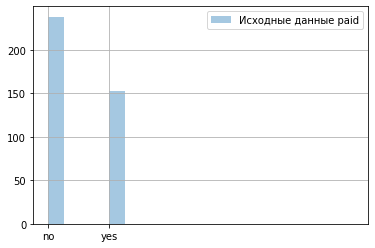

In [170]:
insert_mode(column)
hist_source_data(column)

## 19. Activities

In [171]:
column = 'activities'
info_column(column)

Число уникальных значений: 2 

Число упоминания каждого значения: 
 yes    192
no     185
Name: activities, dtype: int64 

Число пустых значений в столбце: 14 



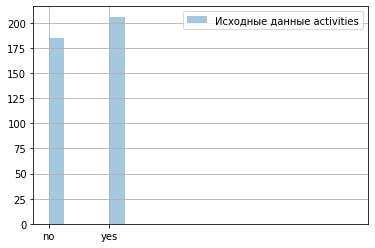

In [172]:
insert_mode(column)
hist_source_data(column)

## 20. Nursery

In [173]:
column = 'nursery'
info_column(column)

Число уникальных значений: 2 

Число упоминания каждого значения: 
 yes    296
no      79
Name: nursery, dtype: int64 

Число пустых значений в столбце: 16 



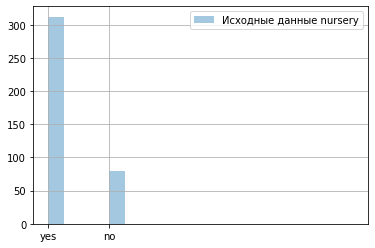

In [174]:
insert_mode(column)
hist_source_data(column)

## 21. Higher

In [175]:
column = 'higher'
info_column(column)

Число уникальных значений: 2 

Число упоминания каждого значения: 
 yes    352
no      19
Name: higher, dtype: int64 

Число пустых значений в столбце: 20 



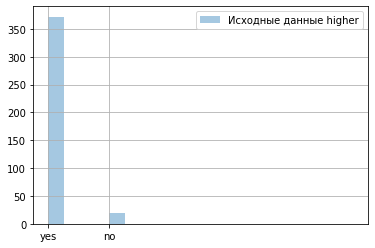

In [176]:
insert_mode(column)
hist_source_data(column)

## 22. Internet

In [177]:
column = 'internet'
info_column(column)

Число уникальных значений: 2 

Число упоминания каждого значения: 
 yes    302
no      55
Name: internet, dtype: int64 

Число пустых значений в столбце: 34 



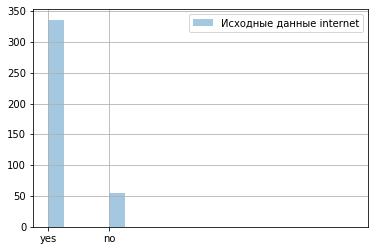

In [178]:
insert_mode(column)
hist_source_data(column)

## 23. Romantic

In [179]:
column = 'romantic'
info_column(column)

Число уникальных значений: 2 

Число упоминания каждого значения: 
 no     238
yes    123
Name: romantic, dtype: int64 

Число пустых значений в столбце: 30 



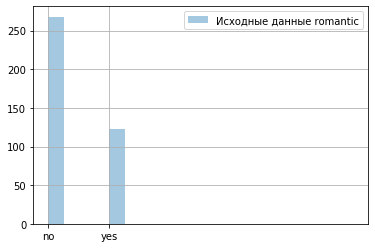

In [180]:
insert_mode(column)
hist_source_data(column)

## 24. Famrel

In [181]:
column = 'famrel'
info_column(column)

Число уникальных значений: 6 

Число упоминания каждого значения: 
  4.0    182
 5.0     98
 3.0     60
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64 

Число пустых значений в столбце: 26 



In [182]:
# удаляем строку с неправильным значением -1
df = df.drop(np.where(df.famrel == -1.0)[0])

25-й перцентиль: 4.0, 75-й перцентиль: 4.75, IQR: 0.75,  Границы выбросов: [2.875, 5.875].


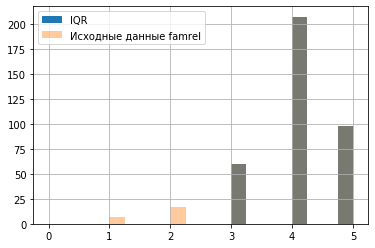

In [183]:
insert_mean(column)
IQR_perc(column)
hist_source_data(column)
# оставляем все данные в  допустимом интервале (0.0 - 5.0)

## 25. Freetime

In [184]:
column = 'freetime'
info_column(column)

Число уникальных значений: 5 

Число упоминания каждого значения: 
 3.0    151
4.0    110
2.0     62
5.0     38
1.0     18
Name: freetime, dtype: int64 

Число пустых значений в столбце: 11 



25-й перцентиль: 3.0, 75-й перцентиль: 4.0, IQR: 1.0,  Границы выбросов: [1.5, 5.5].


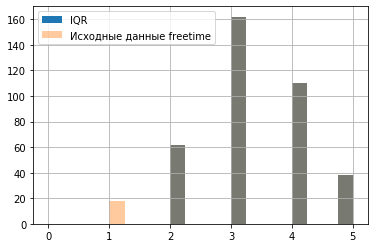

In [185]:
insert_mean(column)
IQR_perc(column)
hist_source_data(column)
# оставляем все данные в  допустимом интервале (0.0 - 5.0)

## 26. Goout

In [186]:
column = 'goout'
info_column(column)

Число уникальных значений: 5 

Число упоминания каждого значения: 
 3.0    125
2.0     99
4.0     84
5.0     52
1.0     23
Name: goout, dtype: int64 

Число пустых значений в столбце: 7 



25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].


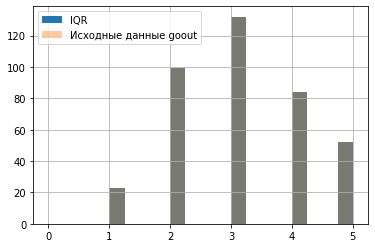

In [187]:
insert_mean(column)
IQR_perc(column)
hist_source_data(column)

## 27. Health

In [188]:
column = 'health'
info_column(column)

Число уникальных значений: 5 

Число упоминания каждого значения: 
 5.0    137
3.0     88
4.0     60
1.0     47
2.0     43
Name: health, dtype: int64 

Число пустых значений в столбце: 15 



25-й перцентиль: 3.0, 75-й перцентиль: 5.0, IQR: 2.0,  Границы выбросов: [0.0, 8.0].


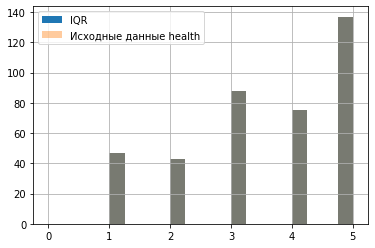

In [189]:
insert_mean(column)
IQR_perc(column)
hist_source_data(column)

## 28. Absences

In [190]:
column = 'absences'
info_column(column)

Число уникальных значений: 36 

Число упоминания каждого значения: 
 0.0     110
2.0      59
4.0      52
6.0      31
8.0      20
       ... 
38.0      1
40.0      1
23.0      1
17.0      1
28.0      1
Name: absences, Length: 36, dtype: int64 

Число пустых значений в столбце: 11 



25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


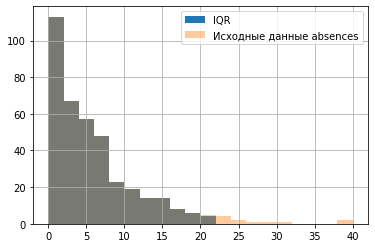

In [191]:
# зададим пределы графика гистограммы до явного выброса: 40
star_point = 0
end_point = 40

insert_mean(column)
IQR_perc(column)
hist_source_data(column)

In [192]:
# Т.к. за пределами стандартных границ выбросов имеется достаточно данных, вручную увеличим размах усов выбросов:
IQR = df[column].quantile(0.75) - df[column].quantile(0.25)
perc25 = df[column].quantile(0.25)
perc75 = df[column].quantile(0.75)

print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR),
      "Границы выбросов: [{f}, {l}].".format(f=perc25 - 2.5*IQR, l=perc75 + 2.5*IQR))

# подсчитаем количество значений, лежащих за пределами удлиненных границ выбросов:
print('Количество значений за пределами удлиненных границ выбросов:',
      len(df.loc[df['absences'] >= 28]))

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-20.0, 28.0].
Количество значений за пределами удлиненных границ выбросов: 9


In [193]:
# Удалим данные выбросы
df = df.drop(df[df['absences'] >= 28].index)

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


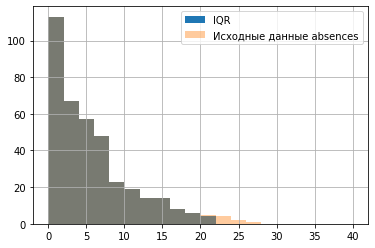

In [194]:
IQR_perc(column)
hist_source_data(column)

## 29. Score

In [195]:
column = 'score'
info_column(column)

Число уникальных значений: 18 

Число упоминания каждого значения: 
 50.0     54
55.0     43
0.0      37
75.0     32
65.0     31
60.0     29
40.0     27
70.0     27
45.0     24
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
95.0      5
85.0      5
100.0     1
20.0      1
Name: score, dtype: int64 

Число пустых значений в столбце: 6 



In [196]:
insert_mode(column)

25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  Границы выбросов: [-5.0, 115.0].


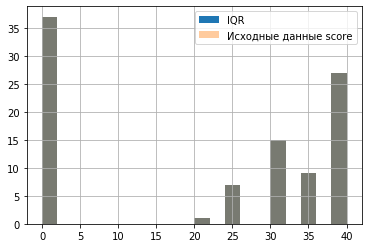

In [197]:
IQR_perc(column)
hist_source_data(column)

In [198]:
# 0 удаляем, т.к. это видимо те кто не явился, или не сдавал работу на проверку.

df = df.drop(df[df['score'] == 0].index)

In [199]:
df

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,GT3,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,yes,yes,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,T,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,no,no,yes,yes,yes,no,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,other,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,MS,F,18,U,LE3,T,3.0,1.0,teacher,services,course,mother,1.0,2.0,0.0,no,yes,yes,no,yes,yes,yes,no,4.0,3.0,4.0,1.0,0.0,40.0
391,MS,M,17,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,no,no,no,no,no,yes,yes,no,2.0,4.0,5.0,2.0,3.0,80.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,mother,1.0,1.0,3.0,no,no,no,no,no,yes,no,no,5.0,5.0,3.0,3.0,3.0,35.0
393,MS,M,18,R,LE3,T,3.0,2.0,services,other,course,mother,3.0,1.0,0.0,no,no,no,yes,no,yes,yes,no,4.0,4.0,1.0,5.0,0.0,50.0


## Корреляционный анализ

In [201]:
# создаем список столбцов с числовыми значениями
list_num = ['age', 'absences','score']
# создаем список столбцов со категориальными значениями
list_obj = list(set(df.columns).difference(list_num))

In [202]:
# датафейм из  столбцов с числовыми значениями
df_num = df.loc[:, df.columns.isin(list_num)]

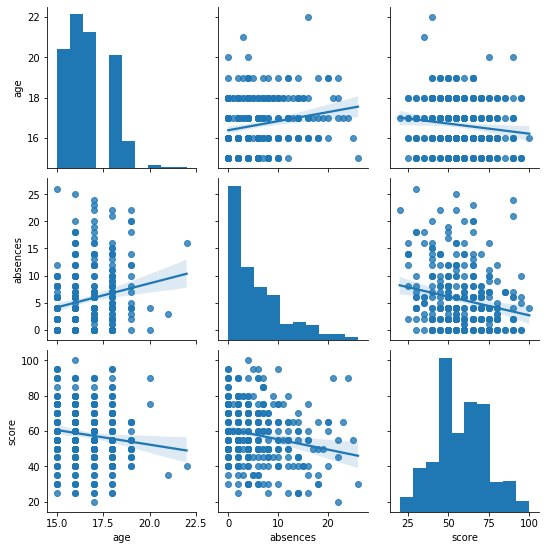

In [203]:
sns.pairplot(df_num, kind='reg')

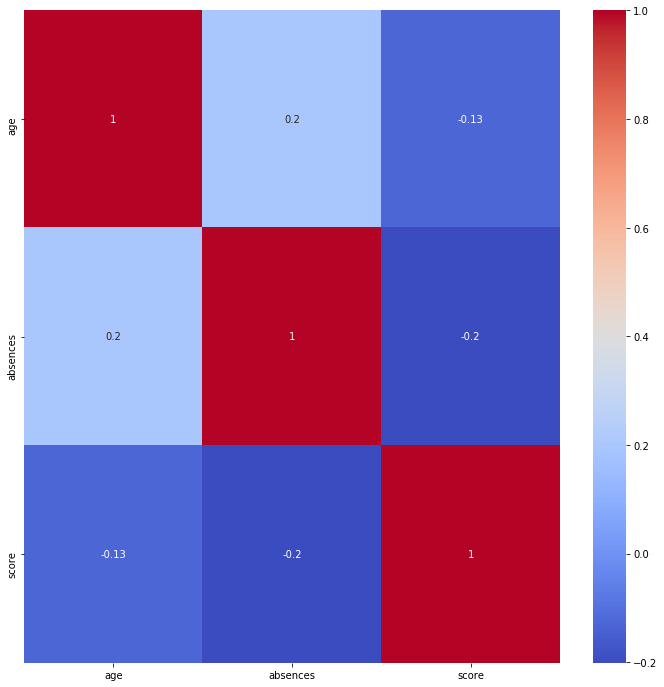

In [204]:
correlation = df_num.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
# Скорррелированных столбцов нет, все столбцы оставляем

## Анализ номинативных переменных

In [205]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score',
                data=df.loc[df.loc[:, column].isin(
                    df.loc[:, column].value_counts().index[:10])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

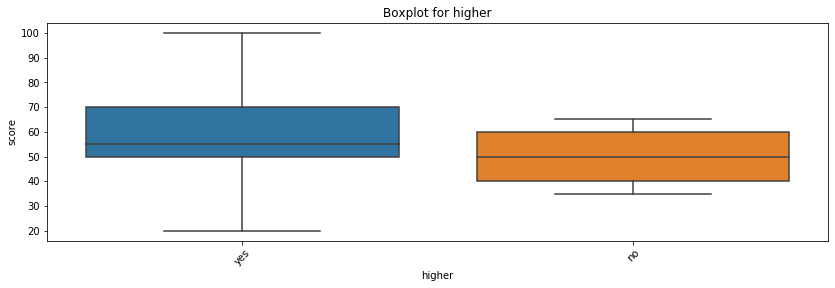

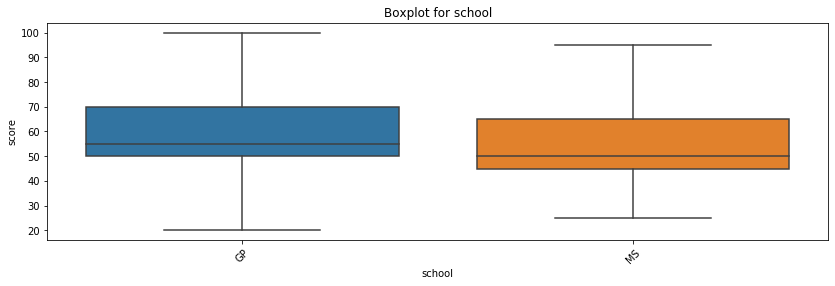

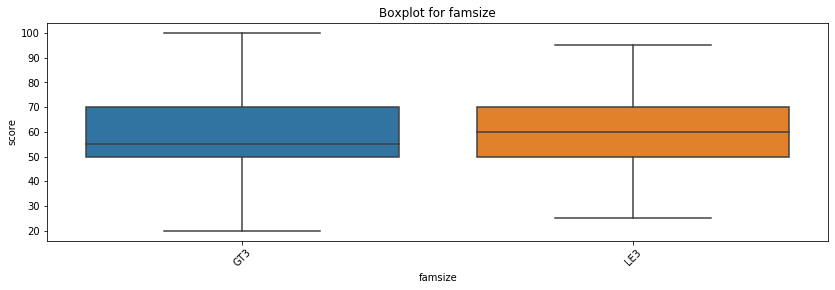

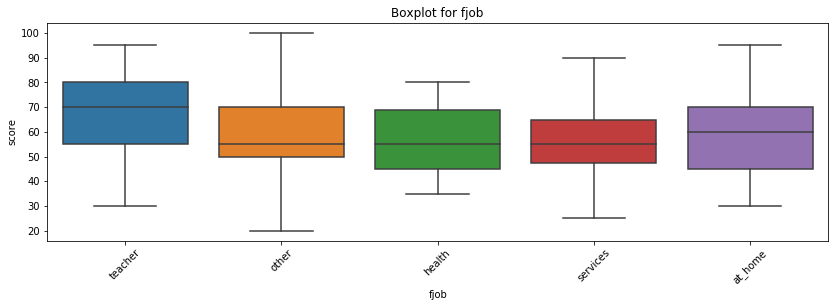

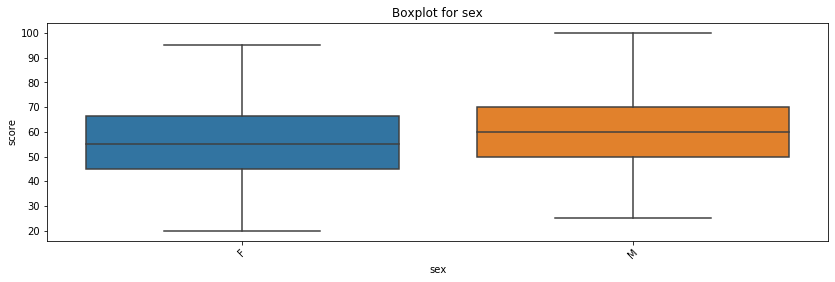

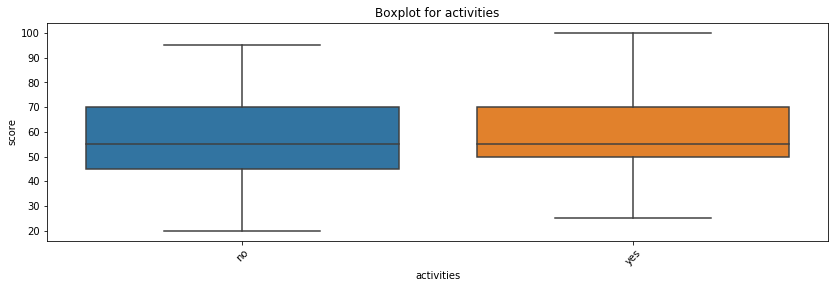

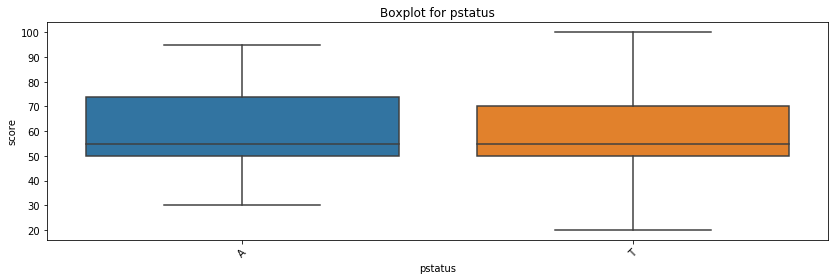

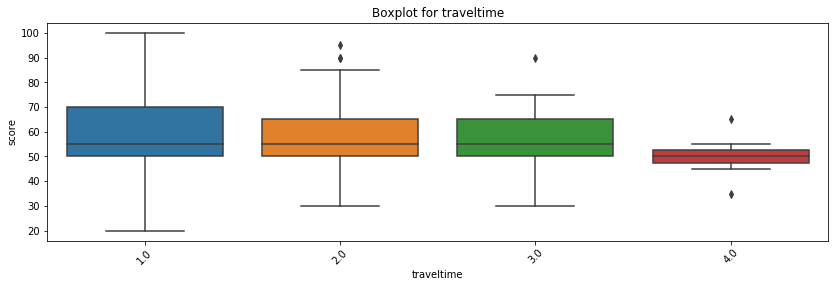

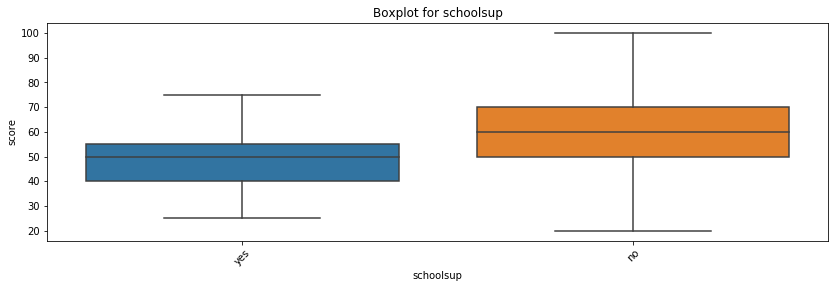

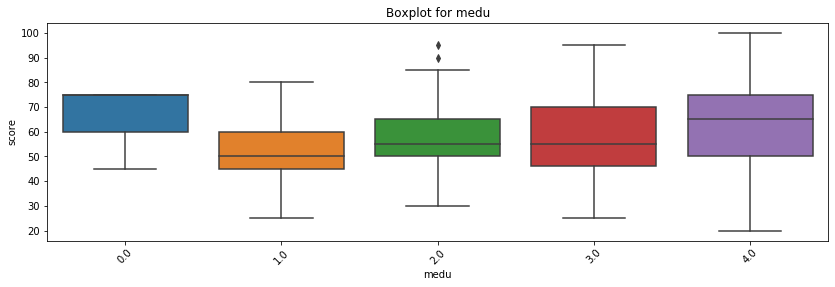

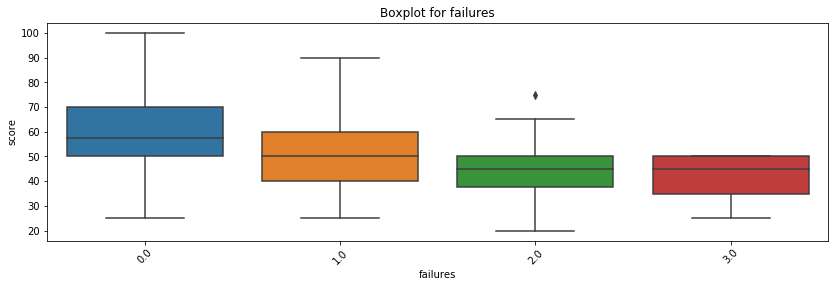

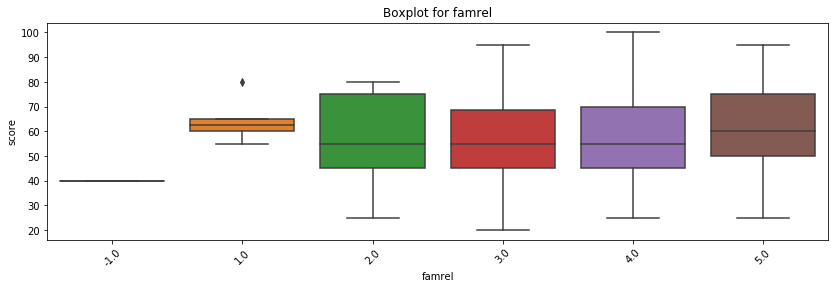

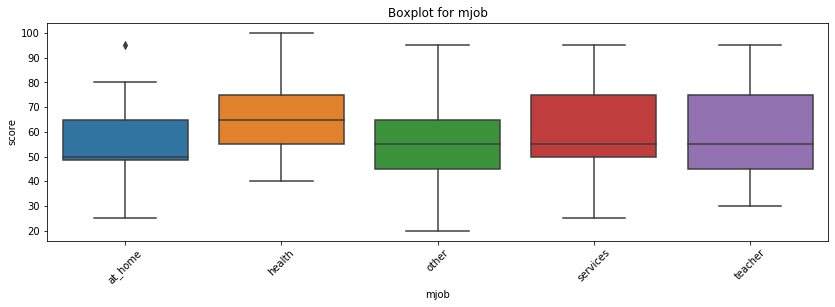

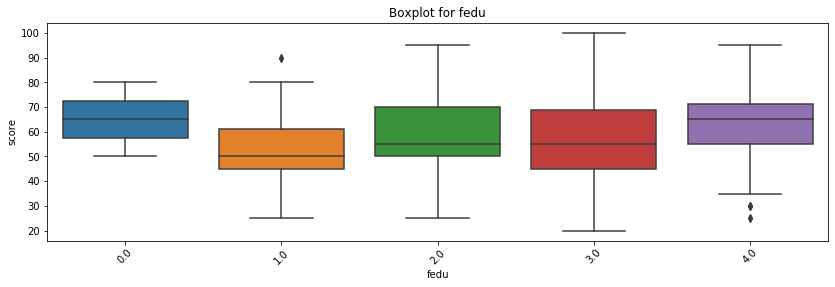

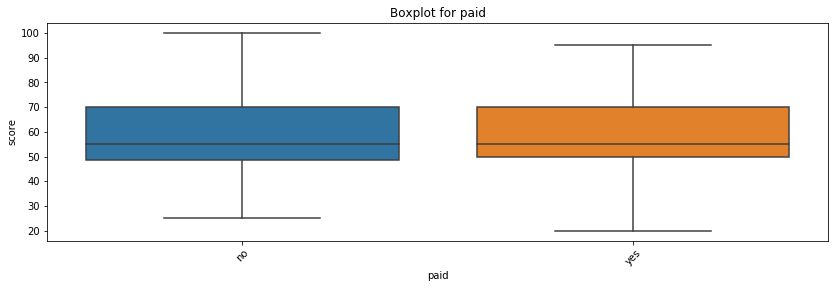

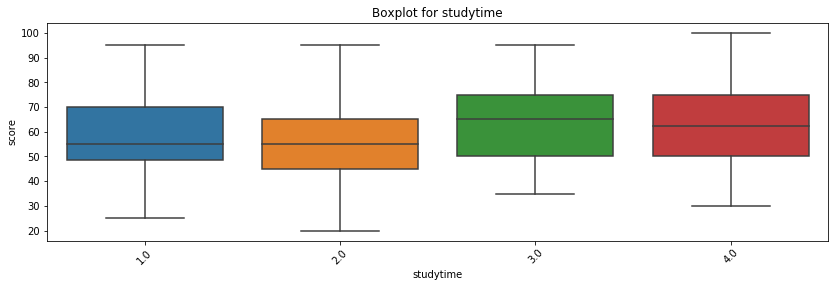

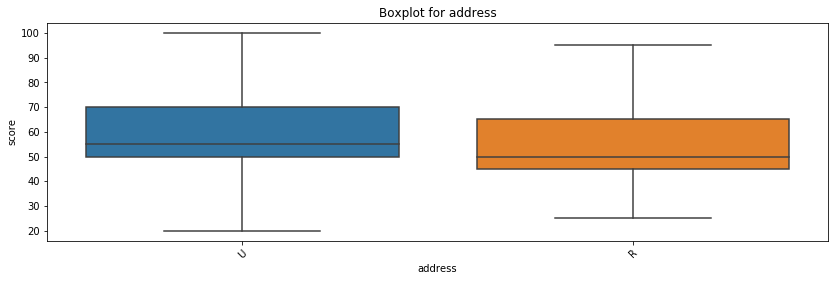

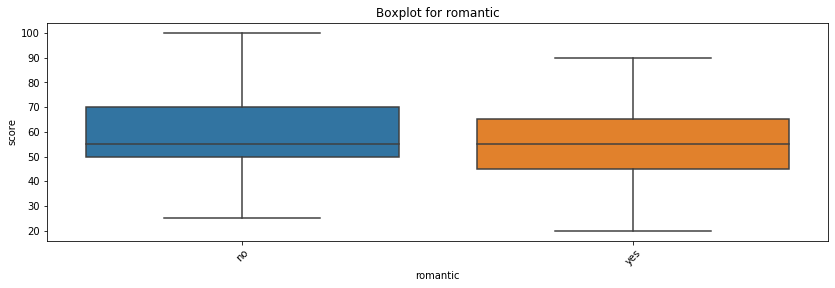

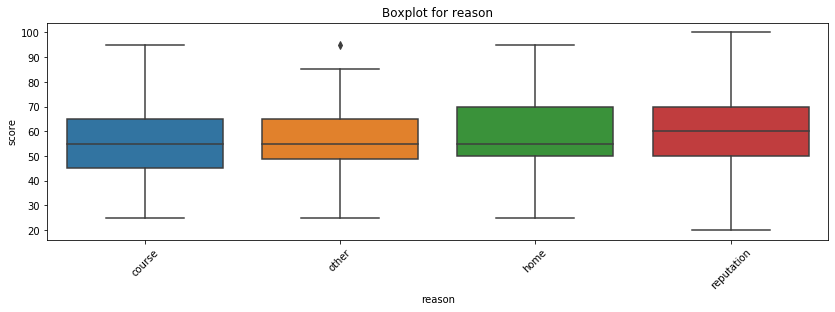

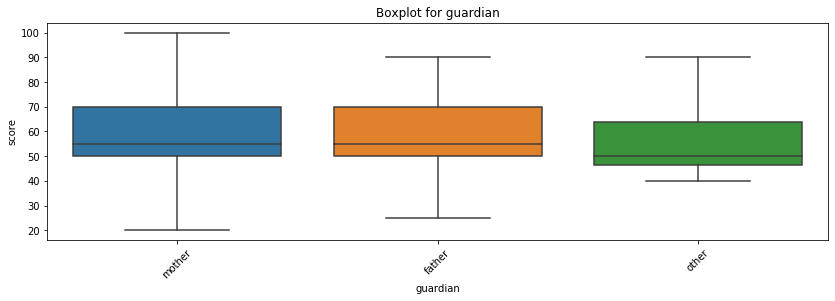

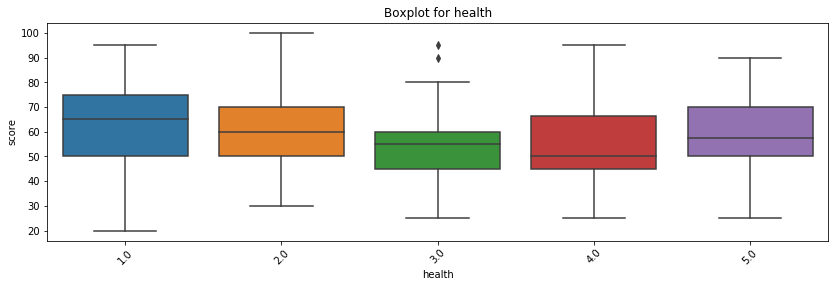

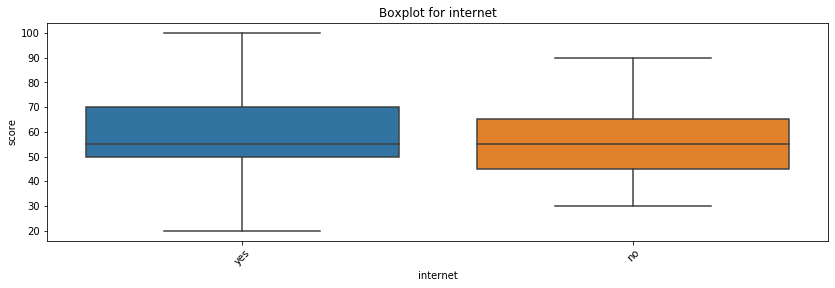

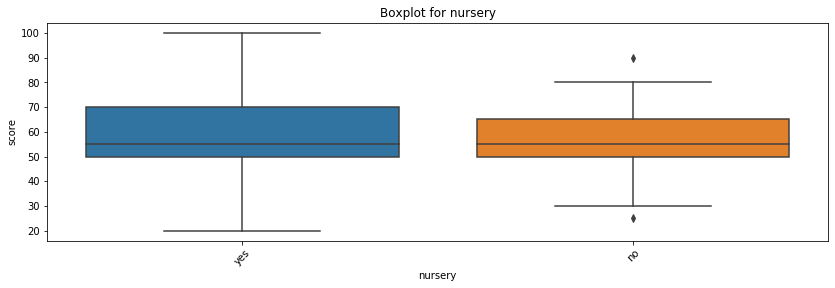

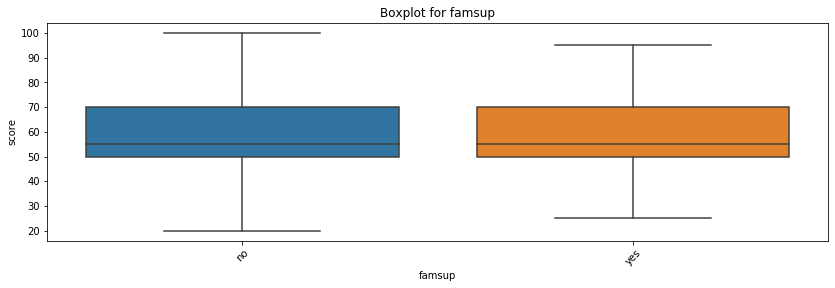

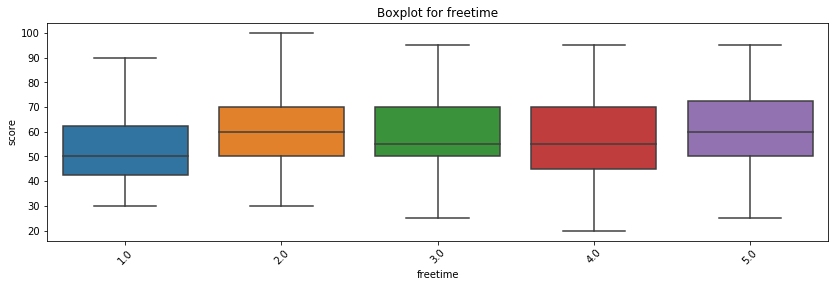

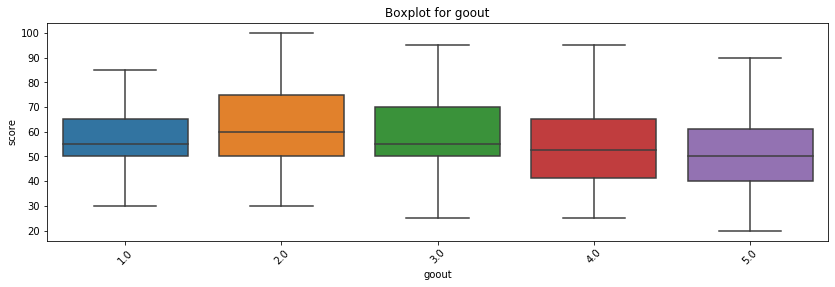

In [206]:
for col in list_obj:
    get_boxplot(col)

In [207]:
# По графикам похоже, что параметры reason, school, paid,guardian не влияют на результаты экзамена по математике

In [212]:

def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'],
                     df.loc[df.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [213]:
for col in list_obj:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки schoolsup
Найдены статистически значимые различия для колонки medu
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки

C:\Users\User\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\User\anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


 fedu
Найдены статистически значимые различия для колонки studytime
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки goout


Как мы видим, в категориальных данных серьёзно отличаются 8 параметров: 'sex', 'address', 'medu', 'fedu',  'schoolsup',  'failures', 'studytime', 'goout'

Оставим эти переменные в датасете для дальнейшего построения модели. 

Итак, в нашем случае важные переменные, которые, возможно, оказывают влияние на оценку экзамена по математике, это: 
'age', 'absences', 'sex', 'failures', 'address', 'medu', 'fedu',  'schoolsup', 'studytime', 'goout'.
И столбец целевой переменной - 'score'


In [214]:
column_for_model = df.loc[:, ['age', 'absences', 'sex', 'failures', 'address', 'medu', 'fedu',  'schoolsup', 'studytime', 'goout', 'score']]
column_for_model.head()

,age,absences,sex,failures,address,medu,fedu,schoolsup,studytime,goout,score
0,18,6.0,F,0.0,U,4.0,4.0,yes,2.0,4.0,30.0
1,17,4.0,F,0.0,U,1.0,1.0,no,2.0,3.0,30.0
2,15,10.0,F,3.0,U,1.0,1.0,yes,2.0,2.0,50.0
3,15,2.0,F,0.0,U,4.0,2.0,no,3.0,2.0,75.0
4,16,4.0,F,0.0,U,3.0,3.0,no,2.0,2.0,50.0


## Выводы.

- В данных мало пустых значений: максимальные пропуски были в столбцах:  pstatus - 12%, famsup - 10% и paid -11%
- выброcы вне пределов нормальных данных были только в одной строке в famrel (-1.0), что говорит о том, что данные достаточно чистые 
- Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, это 'age', 'absences', 'sex', 'failures', 'address', 'medu', 'fedu',  'schoolsup', 'studytime', 'goout', 'score'